In [1]:
scenario = 'vmf3_nograd'

In [2]:
import pandas as pd
import os
import glob
# from google.colab import drive
from datetime import datetime, timedelta, timezone
from tqdm.notebook import tqdm

# # Monta o Google Drive
# drive.mount('/content/drive')

def doy_year_to_date(doy, year):
  """Converts day of year (DOY) and year to a date object.

  Args:
    doy: The day of year (1-366).
    year: The year (e.g., 2023).

  Returns:
    A datetime object representing the date.
  """
  date = datetime(year, 1, 1) + timedelta(days=doy - 1)
  return date


# Função para ler os arquivos de delay
def read_delay_file(file_path):
    try:
        # Lê o arquivo .txt com as colunas separadas por vírgula
        df = pd.read_csv(file_path, header=None)

        # # Verifica se o arquivo tem 13 colunas
        # if df.shape[1] != 13:
        #     print(f"Arquivo {file_path} não tem 11 colunas. Encontrado: {df.shape[1]} colunas.")
        #     return None

        df  = df.iloc[:, :12]

        # Nomeia as colunas
        df.columns = ['grad_e', 'grad_n', 'm_h', 'm_w_orig', 'm_w',
                      'zhd', 'zwd', 'x_0', 'x_1', 'x_2', 'tot_delay','epoca']
        return df
    except Exception as e:
        print(f"Erro ao ler o arquivo {file_path}: {e}")
        return None

# Função para extrair a data a partir do nome do arquivo
def extract_date_from_filename(filepath):
    try:
        # Extrai os 3 números após as 4 primeiras letras (DOY)
        doy = int(filepath.split('_')[-2][-4:-1])

        # Calcula a data a partir do DOY (assumindo ano 2020)
        base_date = pd.Timestamp('2020-01-01')
        return base_date + pd.Timedelta(days=doy - 1)
    except Exception as e:
        print(f"Erro ao extrair a data do nome do arquivo {filepath}: {e}")
        return None

# Estatísticas diárias
def daily_statistics(df):
    grouped = df.groupby(['Estacao', 'Mes', df['Tempo'].dt.date]).agg({
        'grad_e': ['mean', 'std', 'min', 'max'],
        'grad_n': ['mean', 'std', 'min', 'max'],
        'm_h': ['mean', 'std', 'min', 'max'],
        'm_w_orig': ['mean', 'std', 'min', 'max'],
        'm_w': ['mean', 'std', 'min', 'max'],
        'zhd': ['mean', 'std', 'min', 'max'],
        'zwd': ['mean', 'std', 'min', 'max'],
        'x_0': ['mean', 'std', 'min', 'max'],
        'x_1': ['mean', 'std', 'min', 'max'],
        'x_2': ['mean', 'std', 'min', 'max'],
        'tot_delay': ['mean', 'std', 'min', 'max'],
        'tot_delay_abs': lambda x: x.abs().mean()  # Média dos valores absolutos
    })

    # Preserva as colunas Estacao e Mes no índice
    grouped = grouped.reset_index()
    return grouped

# Estatísticas mensais
def monthly_statistics(df):
    grouped = df.groupby(['Estacao', 'Mes']).agg({
        'grad_e': ['mean', 'std', 'min', 'max'],
        'grad_n': ['mean', 'std', 'min', 'max'],
        'm_h': ['mean', 'std', 'min', 'max'],
        'm_w_orig': ['mean', 'std', 'min', 'max'],
        'm_w': ['mean', 'std', 'min', 'max'],
        'zhd': ['mean', 'std', 'min', 'max'],
        'zwd': ['mean', 'std', 'min', 'max'],
        'x_0': ['mean', 'std', 'min', 'max'],
        'x_1': ['mean', 'std', 'min', 'max'],
        'x_2': ['mean', 'std', 'min', 'max'],
        'tot_delay': ['mean', 'std', 'min', 'max'],
        'tot_delay_abs': lambda x: x.abs().mean()  # Média dos valores absolutos
    })

    # Preserva as colunas Estacao e Mes no índice
    grouped = grouped.reset_index()
    return grouped

# def unix_to_utc(unix_seconds):
#     """Convert Unix timestamp (seconds since 1970-01-01) to UTC datetime."""
#     return datetime.utcfromtimestamp(unix_seconds)

def unix_to_utc(unix_seconds):
    """Convert Unix timestamp (seconds since 1970-01-01) to UTC datetime (timezone-aware)."""
    return datetime.fromtimestamp(unix_seconds, tz=timezone.utc)

# GPS Epoch: 1980-01-06 00:00:00 UTC
GPS_EPOCH = datetime(1980, 1, 6, 0, 0, 0)

# Leap seconds offset (as of Jan 2019)
LEAP_SECONDS = 18

def gps_to_utc(gps_seconds):
    """Convert GPS time (seconds since 1980-01-06) to UTC datetime."""
    return GPS_EPOCH + timedelta(seconds=(gps_seconds - LEAP_SECONDS))


# cenario de processamento
all_scenarios = ['orig','orig_nograd',  'vmf3_grads',"vmf3_nograd"]

charts_path = 'charts'

sc_charts_path = os.path.join(charts_path,scenario)

# Caminho base dos arquivos
base_input_path = r'C:\Users\kaue\ufpr.br\Lais Thuany Cardoso Theodoro - VMF3\saidas'
# base_path = f'/content/drive/My Drive/VMF3/dados/{scenario}/'
base_path = os.path.join(base_input_path,scenario)

# Meses e estações RBMC
meses = ['VERAO', 'INVERNO']
estacoes_rbmc = ['BRAZ', 'CUIB', 'UFPR', 'NAUS', 'POAL', 'PERC', 'ONRJ', 'SSA1', 'SAGA', 'POLI']

total_iters = len(meses) * len(estacoes_rbmc) * 31

# DataFrame vazio para armazenar todos os dados
all_daily_data = []
all_monthly_data = []

bar = tqdm(total=total_iters, desc="Processando arquivos", unit="arquivo")

# Itera sobre cada mês e estação RBMC
for mes in meses:

    for estacao in estacoes_rbmc:
        along_monthly_data = []

        # Caminho dos arquivos de delays
        file_path_delays = os.path.join(base_path, mes, estacao, 'delays')

        # Encontra todos os arquivos .txt na pasta delays
        delay_files = glob.glob(os.path.join(file_path_delays, f'{estacao.lower()}*delays.txt'))

        if delay_files:
            print(f"Arquivos encontrados para {mes} e estação {estacao}:")

            # Processa cada arquivo de delay
            for i, filepath in enumerate(delay_files):
                # print(f"Processando o arquivo de delays: {filepath}")

                # Lê os dados do arquivo de delays
                delay_data = read_delay_file(filepath)

                if delay_data is not None:
                    # Extrai a data inicial a partir do nome do arquivo
                    doy = int(filepath.split('_')[-2][-3:-1])
                    date_from_filename = doy_year_to_date(doy, 2020)

                    if date_from_filename is not None:
                        # Gera a coluna de tempo com base no intervalo de 15 segundos
                        delay_data['Tempo'] = delay_data['epoca'].apply(unix_to_utc)
                        # delay_data['Tempo'] = delay_data['epoca']

                        # print(delay_data['Tempo'].min(), delay_data['Tempo'].max())

                        # Adiciona informações de mês e estação ao DataFrame
                        delay_data['Mes'] = mes
                        delay_data['Estacao'] = estacao

                        # Adiciona coluna de valores absolutos
                        delay_data['tot_delay_abs'] = delay_data['tot_delay'].abs()

                        # Calculando a estatística diária:
                        daily_data = daily_statistics(delay_data)

                        # Adiciona os dados à lista global
                        all_daily_data.append(daily_data)

                        # adicionando à estatística mensal:
                        along_monthly_data.append(delay_data)

                bar.update(1)



            montly_df = pd.concat(along_monthly_data, ignore_index=True)
            monthly_data = monthly_statistics(montly_df)
            all_monthly_data.append(monthly_data)

# Concatena os dados em um único DataFrame
daily_stats = pd.concat(all_daily_data, ignore_index=True)
monthly_stats = pd.concat(all_monthly_data, ignore_index=True)

# Salva os resultados em arquivos CSV
# output_path = f'saidas/{scenario}/'
output_path = os.path.join('saidas', scenario)
daily_stats.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in daily_stats.columns]
monthly_stats.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in monthly_stats.columns]


daily_stats_path = os.path.join(output_path, 'daily_stats.csv')
monthly_stats_path = os.path.join(output_path, 'monthly_stats.csv')

daily_stats.to_csv(daily_stats_path, index=False)
monthly_stats.to_csv(monthly_stats_path, index=False)

print("Estatísticas diárias e mensais foram salvas com sucesso!")


Processando arquivos:   0%|          | 0/620 [00:00<?, ?arquivo/s]

Arquivos encontrados para VERAO e estação BRAZ:
Arquivos encontrados para VERAO e estação CUIB:
Arquivos encontrados para VERAO e estação UFPR:
Arquivos encontrados para VERAO e estação NAUS:
Arquivos encontrados para VERAO e estação POAL:
Arquivos encontrados para VERAO e estação PERC:
Arquivos encontrados para VERAO e estação ONRJ:
Arquivos encontrados para VERAO e estação SSA1:
Arquivos encontrados para VERAO e estação SAGA:
Arquivos encontrados para VERAO e estação POLI:
Arquivos encontrados para INVERNO e estação BRAZ:
Arquivos encontrados para INVERNO e estação CUIB:
Arquivos encontrados para INVERNO e estação UFPR:
Arquivos encontrados para INVERNO e estação NAUS:
Arquivos encontrados para INVERNO e estação POAL:
Arquivos encontrados para INVERNO e estação PERC:
Arquivos encontrados para INVERNO e estação ONRJ:
Arquivos encontrados para INVERNO e estação SSA1:
Arquivos encontrados para INVERNO e estação SAGA:
Arquivos encontrados para INVERNO e estação POLI:
Estatísticas diárias

In [3]:
import os
import glob
import pandas as pd

# Caminho base dos arquivos (o mesmo usado no primeiro script)


# DataFrame para armazenar as informações sobre os meses encontrados
months_in_files = []

# Itera sobre cada mês e estação RBMC
for mes in meses:
    for estacao in estacoes_rbmc:
        # Caminho dos arquivos de delays
        file_path_delays = os.path.join(base_path, mes, estacao, 'delays')

        # Encontra todos os arquivos .txt na pasta delays
        delay_files = glob.glob(os.path.join(file_path_delays, f'{estacao.lower()}*delays.txt'))

        # Processa os arquivos encontrados
        for file in delay_files:
            # Extrai o nome do arquivo
            filename = os.path.basename(file)

            # Tenta extrair o DOY e determinar o mês correspondente
            try:
                doy = int(filename[4:7])  # Extrai o DOY (supondo que esteja na posição correta)
                base_date = pd.Timestamp('2020-01-01')  # Ano de referência
                file_date = base_date + pd.Timedelta(days=doy - 1)  # Calcula a data
                file_month = file_date.month_name()  # Obtém o nome do mês

                # Adiciona a informação ao DataFrame
                months_in_files.append({
                    'Mes_Pasta': mes,
                    'Estacao': estacao,
                    'Arquivo': filename,
                    'DOY': doy,
                    'Data': file_date.strftime('%Y-%m-%d'),
                    'Mes_Arquivo': file_month
                })
            except Exception as e:
                print(f"Erro ao processar o arquivo {filename}: {e}")

# Converte a lista em um DataFrame
months_df = pd.DataFrame(months_in_files)

# Salva o DataFrame em um arquivo CSV
# output_path = '/content/drive/My Drive/VMF3/dados/orig/'
# output_path = f'saidas/{scenario}/' 
output_path = os.path.join('saidas', scenario)

sc_outpath = os.path.join('saidas', scenario)

output_file = os.path.join(output_path, 'months_in_files.csv')
months_df.to_csv(output_file, index=False)

print(f"Informações sobre os meses foram salvas em {output_file}")


Informações sobre os meses foram salvas em saidas\vmf3_nograd\months_in_files.csv


In [4]:
import pandas as pd
import os

# Caminho para o arquivo daily_stats.csv
file_path = daily_stats_path

# Lê o arquivo daily_stats.csv
try:
    daily_stats = pd.read_csv(file_path)

    # Exibe as colunas do arquivo para verificar a coluna de tempo
    print("Colunas disponíveis no arquivo:", daily_stats.columns)

    # Verifica se a coluna 'Tempo_' existe
    if 'Tempo_' in daily_stats.columns:
        # Converte a coluna 'Tempo_' para datetime, se necessário
        daily_stats['Tempo_'] = pd.to_datetime(daily_stats['Tempo_'], errors='coerce')

        # Remove entradas inválidas
        valid_dates = daily_stats.dropna(subset=['Tempo_'])

        # Extrai os meses únicos
        months_in_data = valid_dates['Tempo_'].dt.month_name().unique()

        print("Meses presentes no arquivo daily_stats.csv:")
        for month in sorted(months_in_data):
            print(month)

        # Salva os meses em um arquivo CSV
        # output_path = f'saidas/{scenario}/months_in_daily_stats.csv'
        output_path = os.path.join(sc_outpath, 'months_in_daily_stats.csv')
        pd.DataFrame({'Meses': sorted(months_in_data)}).to_csv(output_path, index=False)

        print(f"Lista de meses salva em {output_path}")
    else:
        print("A coluna 'Tempo_' não foi encontrada no arquivo.")

except Exception as e:
    print(f"Erro ao processar o arquivo: {e}")


Colunas disponíveis no arquivo: Index(['Estacao_', 'Mes_', 'Tempo_', 'grad_e_mean', 'grad_e_std', 'grad_e_min',
       'grad_e_max', 'grad_n_mean', 'grad_n_std', 'grad_n_min', 'grad_n_max',
       'm_h_mean', 'm_h_std', 'm_h_min', 'm_h_max', 'm_w_orig_mean',
       'm_w_orig_std', 'm_w_orig_min', 'm_w_orig_max', 'm_w_mean', 'm_w_std',
       'm_w_min', 'm_w_max', 'zhd_mean', 'zhd_std', 'zhd_min', 'zhd_max',
       'zwd_mean', 'zwd_std', 'zwd_min', 'zwd_max', 'x_0_mean', 'x_0_std',
       'x_0_min', 'x_0_max', 'x_1_mean', 'x_1_std', 'x_1_min', 'x_1_max',
       'x_2_mean', 'x_2_std', 'x_2_min', 'x_2_max', 'tot_delay_mean',
       'tot_delay_std', 'tot_delay_min', 'tot_delay_max',
       'tot_delay_abs_<lambda>'],
      dtype='object')
Meses presentes no arquivo daily_stats.csv:
January
July
Lista de meses salva em saidas\vmf3_nograd\months_in_daily_stats.csv


In [5]:
daily_stats

,Estacao_,Mes_,Tempo_,grad_e_mean,grad_e_std,grad_e_min,grad_e_max,grad_n_mean,grad_n_std,grad_n_min,...,x_1_max,x_2_mean,x_2_std,x_2_min,x_2_max,tot_delay_mean,tot_delay_std,tot_delay_min,tot_delay_max,tot_delay_abs_<lambda>
0,BRAZ,VERAO,2020-01-01,-0.175940,0.041764,-0.273000,-0.104000,0.197866,0.060311,0.102000,...,0,0.0,0.0,0,0,5.851987,3.596578,2.335316,17.969151,5.851987
1,BRAZ,VERAO,2020-01-02,0.152220,0.108079,-0.134000,0.296000,0.047329,0.072421,-0.075000,...,0,0.0,0.0,0,0,5.881570,3.603277,2.353306,18.206534,5.881570
2,BRAZ,VERAO,2020-01-03,0.098819,0.060908,0.016042,0.236000,0.165372,0.088642,-0.071828,...,0,0.0,0.0,0,0,5.924545,3.642175,2.359922,18.221266,5.924545
3,BRAZ,VERAO,2020-01-04,0.109874,0.118299,-0.101000,0.355683,0.119089,0.070201,-0.072000,...,0,0.0,0.0,0,0,5.935112,3.647796,2.374431,18.227820,5.935112
4,BRAZ,VERAO,2020-01-05,0.356860,0.095417,0.220254,0.586000,0.421010,0.119425,0.232000,...,0,0.0,0.0,0,0,5.910390,3.633437,2.352468,18.196901,5.910390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,POLI,INVERNO,2020-07-27,0.098369,0.032708,0.062000,0.203903,0.053550,0.043561,-0.015000,...,0,0.0,0.0,0,0,5.520418,3.417533,2.323978,17.737443,5.520418
616,POLI,INVERNO,2020-07-28,-0.039351,0.104595,-0.224000,0.204000,0.105564,0.054853,0.023149,...,0,0.0,0.0,0,0,5.532478,3.424896,2.307280,17.890225,5.532478
617,POLI,INVERNO,2020-07-29,-0.050557,0.095792,-0.227000,0.094000,-0.176143,0.169567,-0.466803,...,0,0.0,0.0,0,0,5.695540,3.523737,2.349605,18.245910,5.695540
618,POLI,INVERNO,2020-07-30,0.211584,0.082892,-0.076000,0.355000,0.302601,0.302852,-0.467000,...,0,0.0,0.0,0,0,5.676677,3.516649,2.384832,18.273484,5.676677


In [6]:
import pandas as pd
# from google.colab import drive
# drive.mount('/content/drive')

# Listar os arquivos na pasta para verificar se 'daily_stats.csv' está presente
import os
# base_path = '/content/drive/My Drive/VMF3/dados/orig/'
print(os.listdir(base_path))


# Caminho dos arquivos CSV
# daily_stats_path = '/content/drive/My Drive/VMF3/dados/orig/daily_stats.csv'
# monthly_stats_path = '/content/drive/My Drive/VMF3/dados/orig/monthly_stats.csv'

# Carrega os arquivos CSV
daily_stats = pd.read_csv(daily_stats_path)
monthly_stats = pd.read_csv(monthly_stats_path)

# Verifica as primeiras linhas para garantir que os dados foram carregados corretamente
print(daily_stats.head())
print(monthly_stats.head())


['INVERNO', 'VERAO']
  Estacao_   Mes_      Tempo_  grad_e_mean  grad_e_std  grad_e_min  \
0     BRAZ  VERAO  2020-01-01    -0.175940    0.041764   -0.273000   
1     BRAZ  VERAO  2020-01-02     0.152220    0.108079   -0.134000   
2     BRAZ  VERAO  2020-01-03     0.098819    0.060908    0.016042   
3     BRAZ  VERAO  2020-01-04     0.109874    0.118299   -0.101000   
4     BRAZ  VERAO  2020-01-05     0.356860    0.095417    0.220254   

   grad_e_max  grad_n_mean  grad_n_std  grad_n_min  ...  x_1_max  x_2_mean  \
0   -0.104000     0.197866    0.060311    0.102000  ...        0       0.0   
1    0.296000     0.047329    0.072421   -0.075000  ...        0       0.0   
2    0.236000     0.165372    0.088642   -0.071828  ...        0       0.0   
3    0.355683     0.119089    0.070201   -0.072000  ...        0       0.0   
4    0.586000     0.421010    0.119425    0.232000  ...        0       0.0   

   x_2_std  x_2_min  x_2_max  tot_delay_mean  tot_delay_std  tot_delay_min  \
0      0.0 

Colunas do DataFrame: Index(['Estacao_', 'Mes_', 'Tempo_', 'grad_e_mean', 'grad_e_std', 'grad_e_min',
       'grad_e_max', 'grad_n_mean', 'grad_n_std', 'grad_n_min', 'grad_n_max',
       'm_h_mean', 'm_h_std', 'm_h_min', 'm_h_max', 'm_w_orig_mean',
       'm_w_orig_std', 'm_w_orig_min', 'm_w_orig_max', 'm_w_mean', 'm_w_std',
       'm_w_min', 'm_w_max', 'zhd_mean', 'zhd_std', 'zhd_min', 'zhd_max',
       'zwd_mean', 'zwd_std', 'zwd_min', 'zwd_max', 'x_0_mean', 'x_0_std',
       'x_0_min', 'x_0_max', 'x_1_mean', 'x_1_std', 'x_1_min', 'x_1_max',
       'x_2_mean', 'x_2_std', 'x_2_min', 'x_2_max', 'tot_delay_mean',
       'tot_delay_std', 'tot_delay_min', 'tot_delay_max',
       'tot_delay_abs_<lambda>'],
      dtype='object')


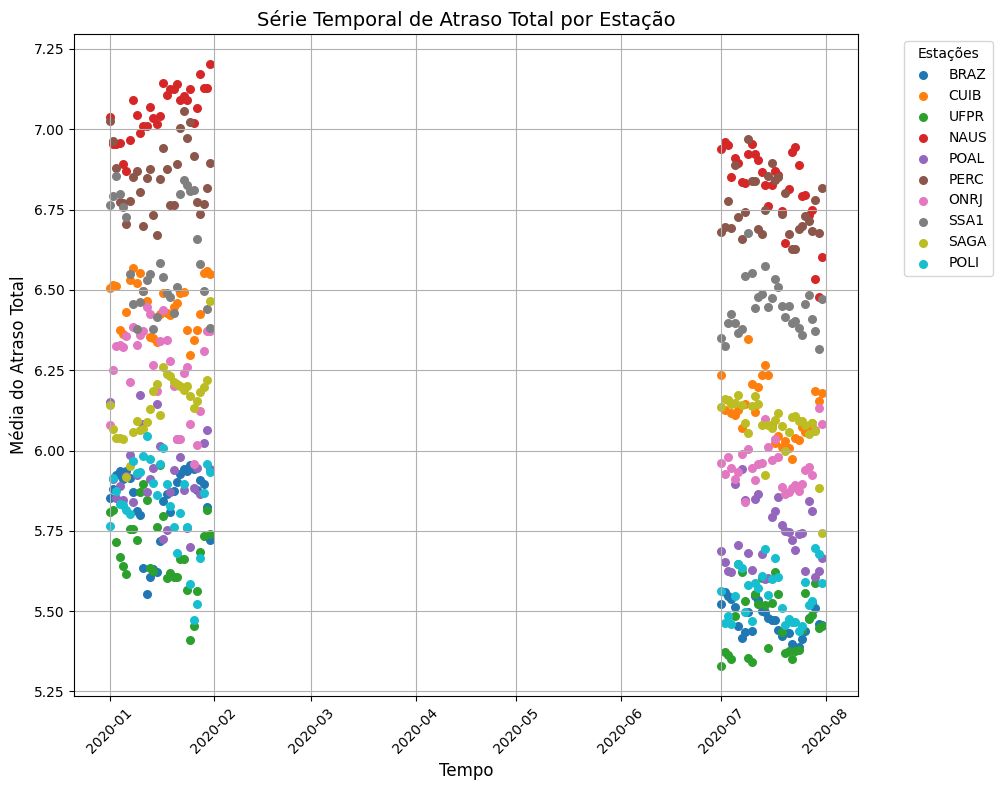

Gráfico geral salvo em: charts\vmf3_nograd\serie_temporal_tot_delay_scatter_legenda_ajustada.png


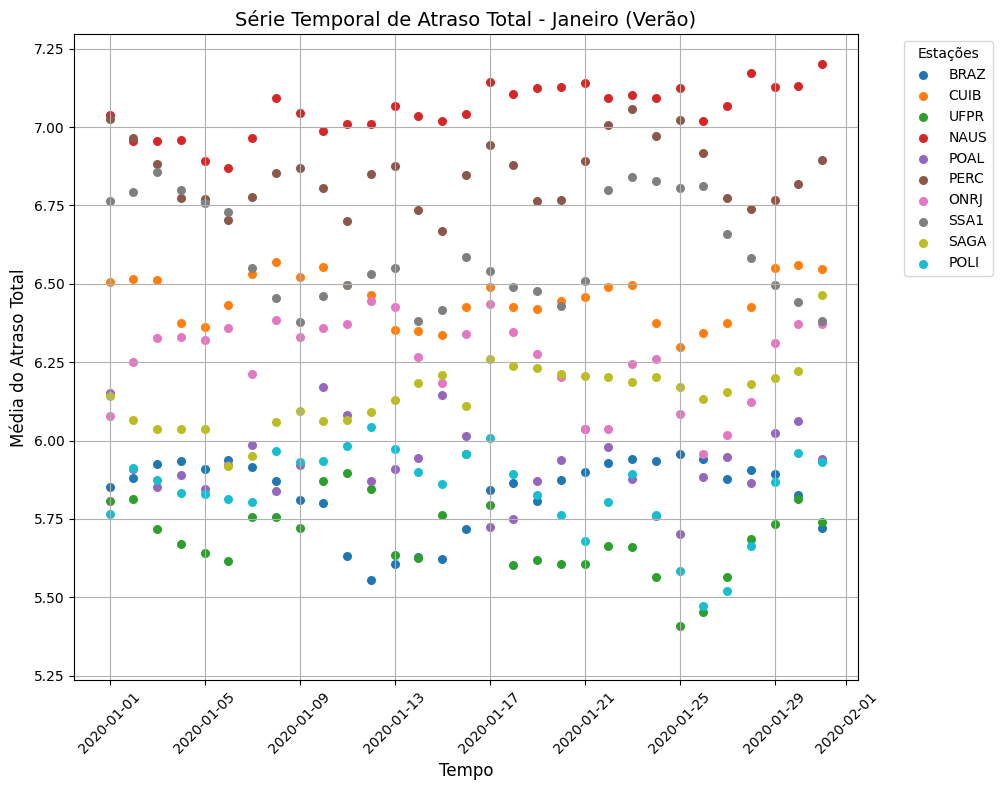

Gráfico de Janeiro (Verão) salvo em: charts\vmf3_nograd\serie_temporal_tot_delay_janeiro.png


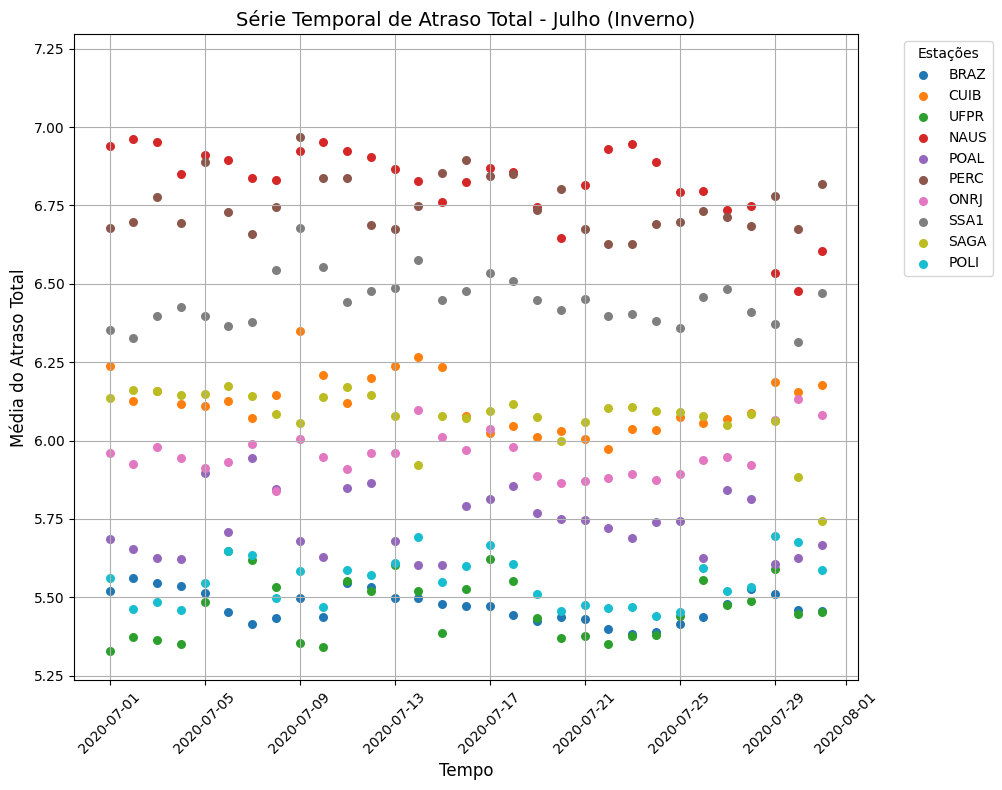

Gráfico de Julho (Inverno) salvo em: charts\vmf3_nograd\serie_temporal_tot_delay_julho.png


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados do arquivo CSV
# daily_stats = pd.read_csv('/content/drive/My Drive/VMF3/dados/orig/daily_stats.csv')
daily_stats = pd.read_csv(daily_stats_path)

# Verificar os nomes das colunas
print("Colunas do DataFrame:", daily_stats.columns)

# Renomear as colunas para os nomes esperados
daily_stats.rename(columns={'Estacao_': 'Estacao', 'Tempo_': 'Tempo'}, inplace=True)

# Garantir que a coluna 'Tempo' esteja no formato datetime
daily_stats['Tempo'] = pd.to_datetime(daily_stats['Tempo'], errors='coerce')

# Estações RBMC
estacoes_rbmc = ['BRAZ', 'CUIB', 'UFPR', 'NAUS', 'POAL', 'PERC', 'ONRJ', 'SSA1', 'SAGA', 'POLI']

# Paleta de cores
colors = plt.cm.tab10.colors  # Paleta de cores com até 10 cores bem distintas

# Determinar os limites do eixo Y com base nos dados completos
y_min = daily_stats['tot_delay_mean'].min()
y_max = daily_stats['tot_delay_mean'].max()

# Adicionar uma margem de segurança para os limites do eixo Y
y_margin = (y_max - y_min) * 0.05  # 5% de margem
y_min -= y_margin
y_max += y_margin

# Função para gerar gráficos de séries temporais com a mesma escala no eixo Y
def gerar_grafico(estacoes, dados, titulo, output_path):
    plt.figure(figsize=(12, 8))

    for idx, estacao in enumerate(estacoes):
        estacao_data = dados[dados['Estacao'] == estacao]
        plt.scatter(estacao_data['Tempo'], estacao_data['tot_delay_mean'],
                    label=estacao, color=colors[idx % len(colors)], s=30)  # Gráfico de pontos

    # Configurações do gráfico
    plt.xlabel('Tempo', fontsize=12)
    plt.ylabel('Média do Atraso Total', fontsize=12)
    plt.title(titulo, fontsize=14)
    plt.ylim(y_min, y_max)  # Definir os mesmos limites do eixo Y para todos os gráficos

    # Posicionar a legenda fora do gráfico
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10, title="Estações")

    # Ajustar o layout para caber tudo
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Ajusta a área do gráfico para incluir a legenda

    # Salvar a imagem no caminho especificado
    plt.savefig(output_path, dpi=300, bbox_inches='tight')  # Salva com alta qualidade e ajusta margens

    # Exibir o gráfico
    plt.show()

# Gráfico geral para todas as estações
# output_path_geral = f'charts/{scenario}/serie_temporal_tot_delay_scatter_legenda_ajustada.png'
output_path_geral = os.path.join(sc_charts_path,'serie_temporal_tot_delay_scatter_legenda_ajustada.png')
gerar_grafico(estacoes_rbmc, daily_stats, 'Série Temporal de Atraso Total por Estação', output_path_geral)
print(f'Gráfico geral salvo em: {output_path_geral}')

# Filtrando os dados para janeiro (verão) e julho (inverno)
verao_data = daily_stats[daily_stats['Tempo'].dt.month == 1]  # Janeiro (Verão)
inverno_data = daily_stats[daily_stats['Tempo'].dt.month == 7]  # Julho (Inverno)

# Gráfico para janeiro (verão)
# output_path_verao = f'charts/{scenario}/serie_temporal_tot_delay_janeiro.png'
output_path_verao = os.path.join(sc_charts_path,'serie_temporal_tot_delay_janeiro.png')

gerar_grafico(estacoes_rbmc, verao_data, 'Série Temporal de Atraso Total - Janeiro (Verão)', output_path_verao)
print(f'Gráfico de Janeiro (Verão) salvo em: {output_path_verao}')

# Gráfico para julho (inverno)
# output_path_inverno = f'charts/{scenario}/serie_temporal_tot_delay_julho.png'
output_path_inverno = os.path.join(sc_charts_path,'serie_temporal_tot_delay_julho.png')


gerar_grafico(estacoes_rbmc, inverno_data, 'Série Temporal de Atraso Total - Julho (Inverno)', output_path_inverno)
print(f'Gráfico de Julho (Inverno) salvo em: {output_path_inverno}')


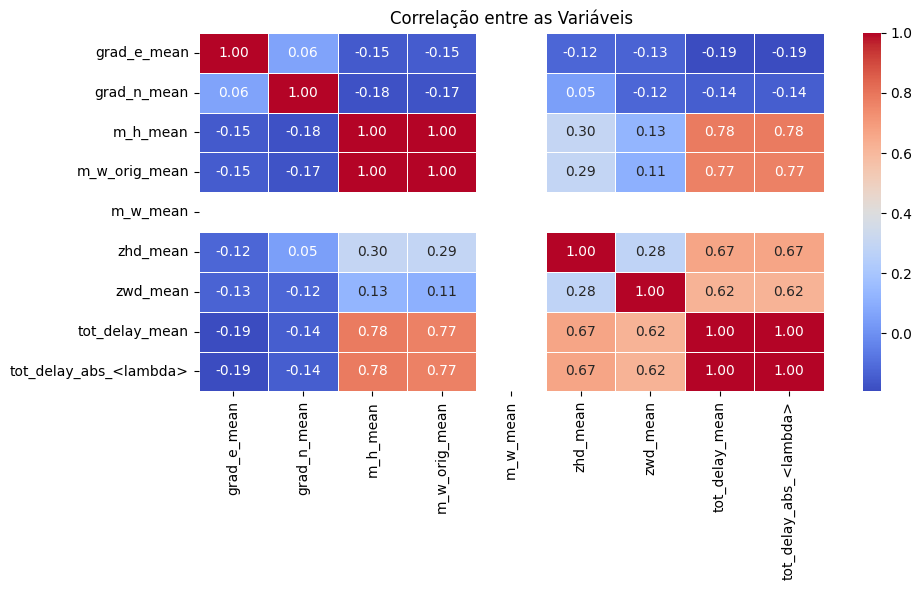

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao.png


In [8]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados do arquivo CSV gerado anteriormente
# daily_stats = pd.read_csv('/content/drive/My Drive/VMF3/dados/orig/daily_stats.csv')
daily_stats = pd.read_csv(daily_stats_path)

# Selecionando apenas as colunas numéricas para a correlação
numerical_columns = ['grad_e_mean', 'grad_n_mean', 'm_h_mean', 'm_w_orig_mean', 'm_w_mean',
                     'zhd_mean', 'zwd_mean', 'tot_delay_mean', 'tot_delay_abs_<lambda>']#'tot_delay_abs_mean']
correlation_data = daily_stats[numerical_columns]

# Calculando a correlação
correlation_matrix = correlation_data.corr()

# Plotando o Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlação entre as Variáveis')
plt.tight_layout()

# Caminho para salvar a imagem
# output_path = '/content/drive/My Drive/VMF3/dados/orig/heatmap_correlacao.png'
output_path = os.path.join(sc_charts_path,'heatmap_correlacao.png')

# Salvando a imagem
plt.savefig(output_path)

# Exibindo o gráfico
plt.show()

print(f"O gráfico foi salvo com sucesso em: {output_path}")


Correlação para a Estação: BRAZ, Mês: INVERNO


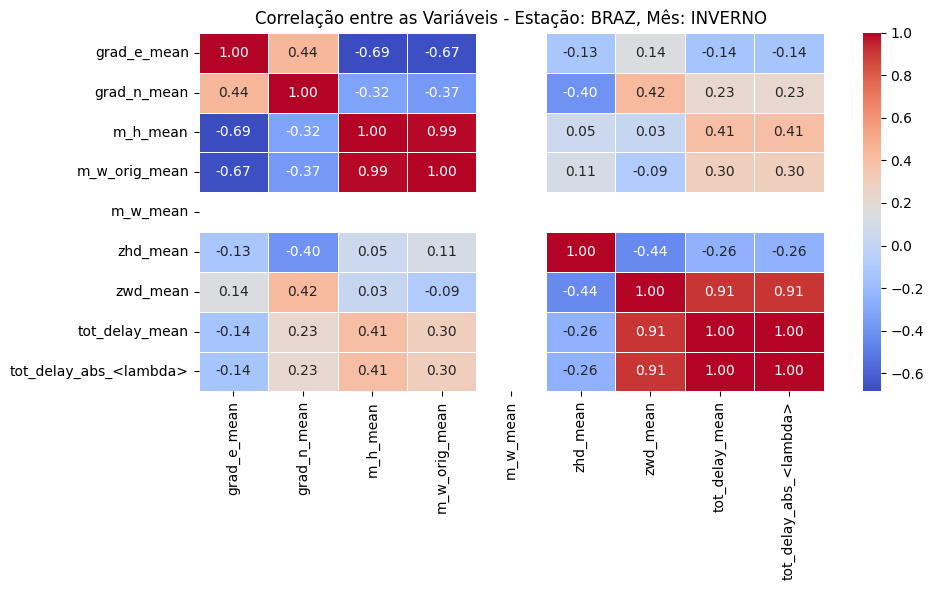

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_BRAZ_INVERNO.png
Correlação para a Estação: BRAZ, Mês: VERAO


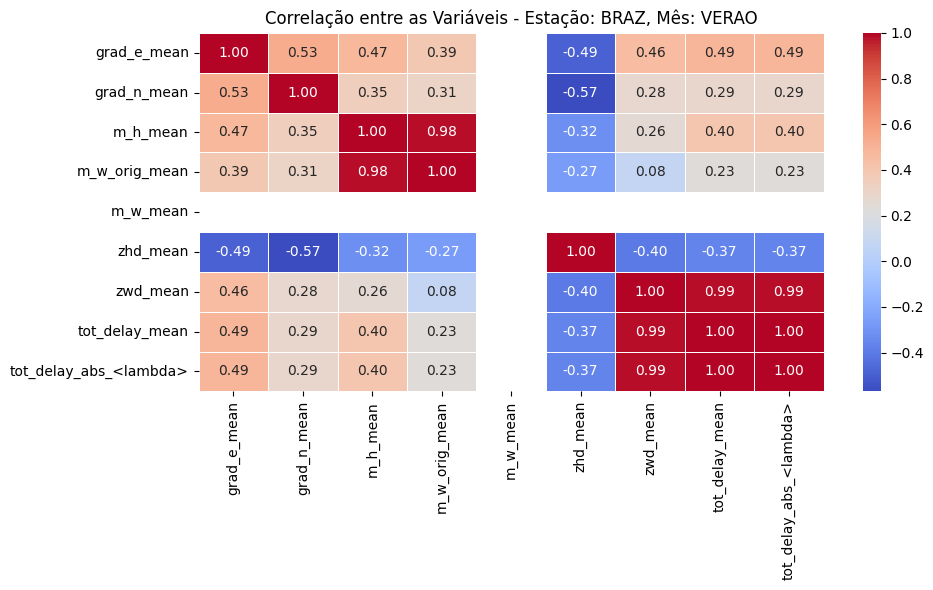

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_BRAZ_VERAO.png
Correlação para a Estação: CUIB, Mês: INVERNO


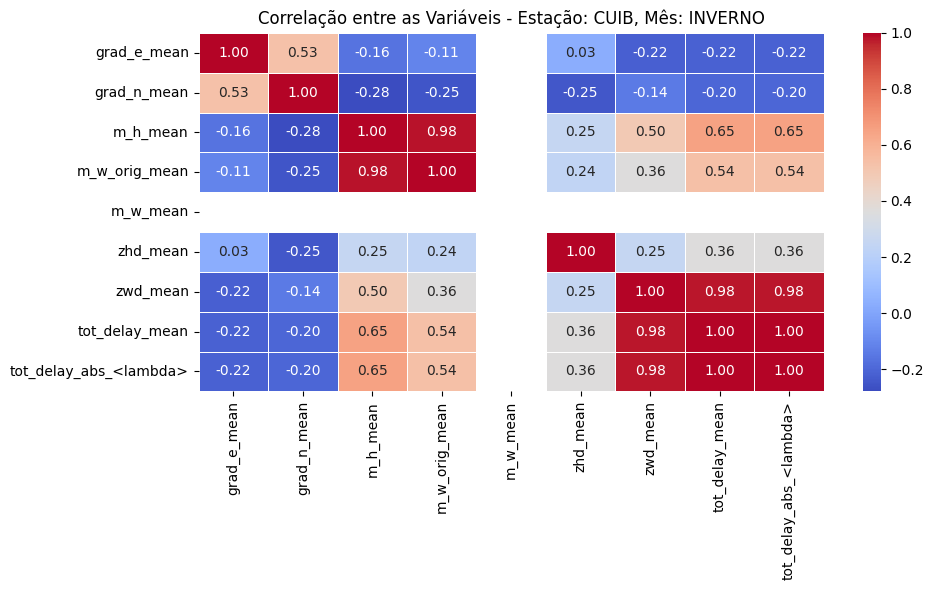

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_CUIB_INVERNO.png
Correlação para a Estação: CUIB, Mês: VERAO


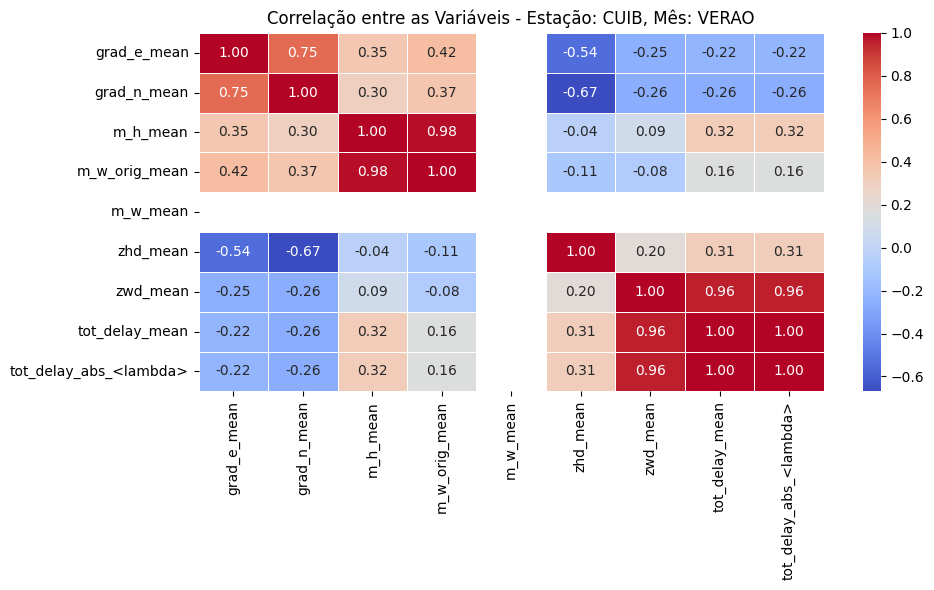

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_CUIB_VERAO.png
Correlação para a Estação: NAUS, Mês: INVERNO


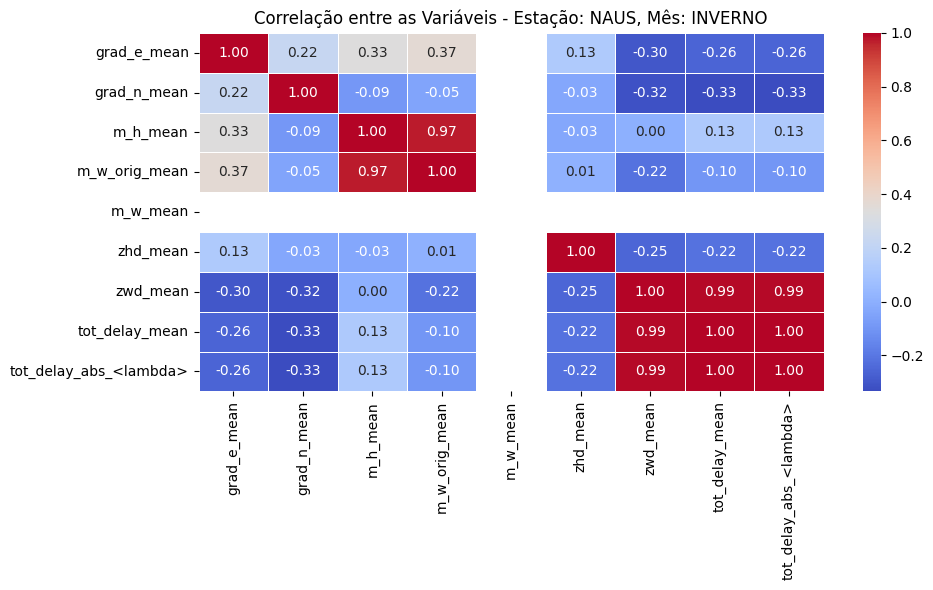

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_NAUS_INVERNO.png
Correlação para a Estação: NAUS, Mês: VERAO


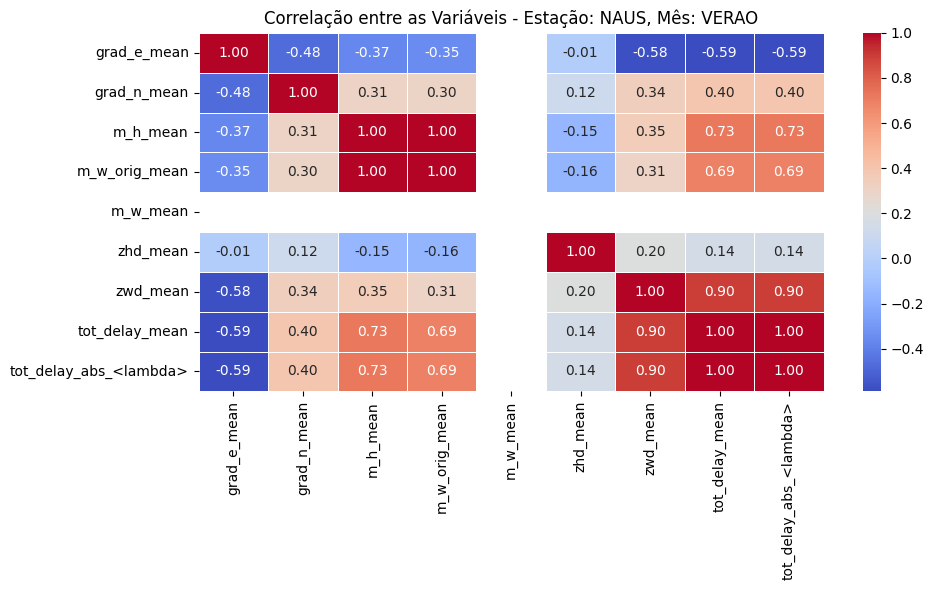

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_NAUS_VERAO.png
Correlação para a Estação: ONRJ, Mês: INVERNO


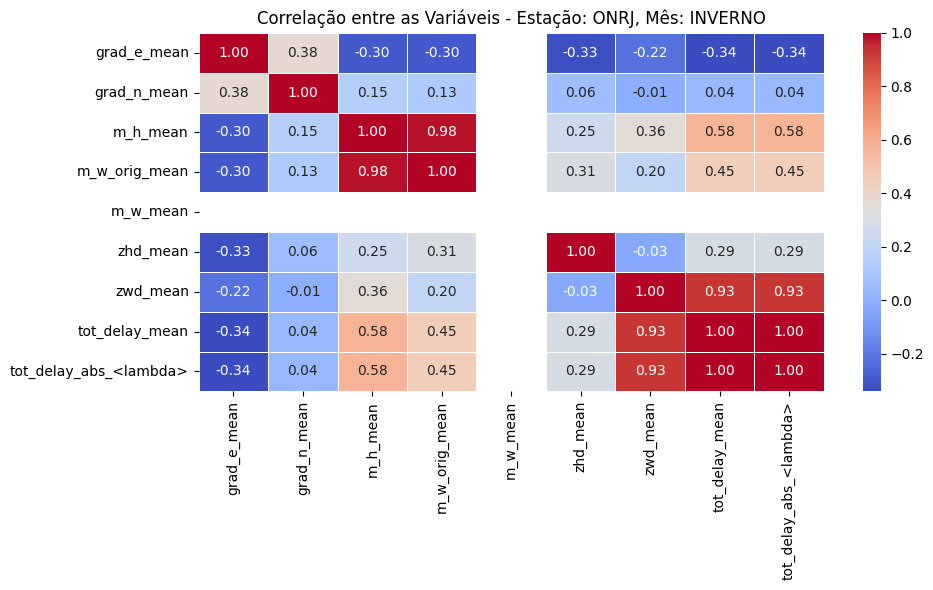

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_ONRJ_INVERNO.png
Correlação para a Estação: ONRJ, Mês: VERAO


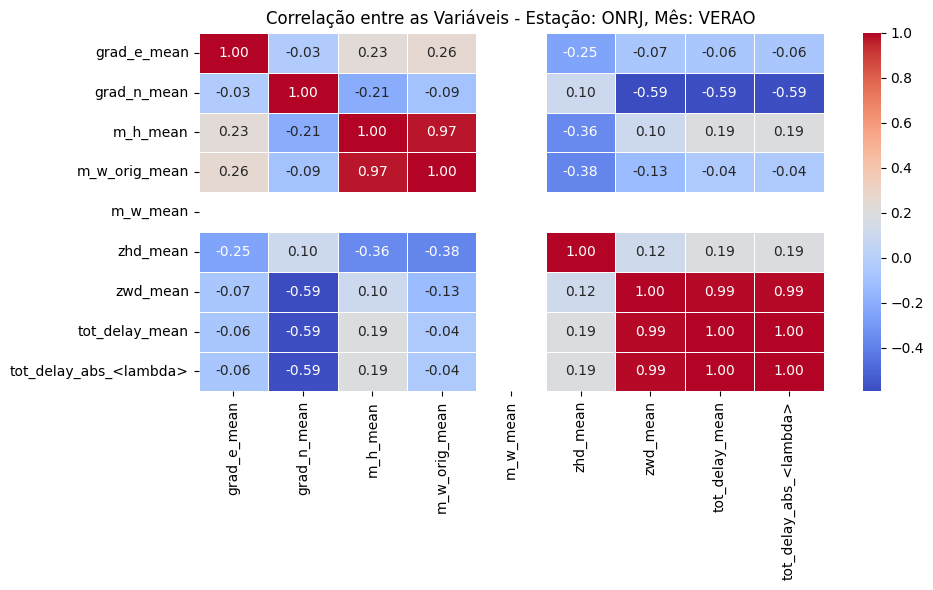

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_ONRJ_VERAO.png
Correlação para a Estação: PERC, Mês: INVERNO


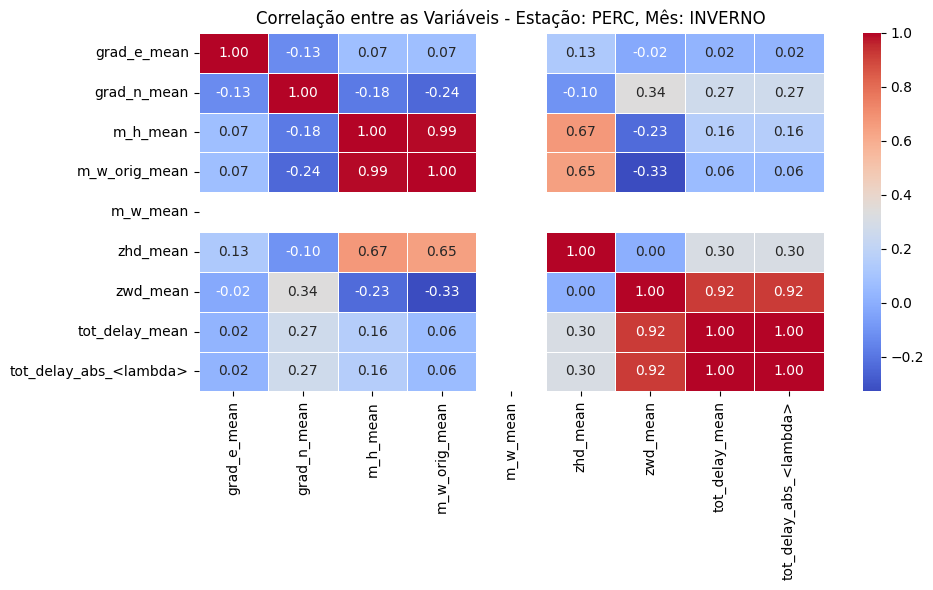

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_PERC_INVERNO.png
Correlação para a Estação: PERC, Mês: VERAO


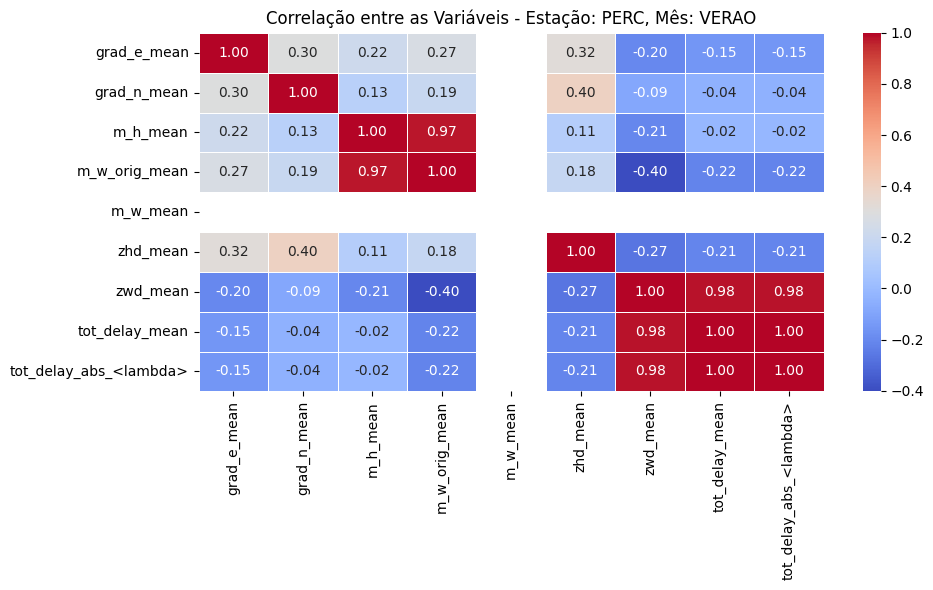

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_PERC_VERAO.png
Correlação para a Estação: POAL, Mês: INVERNO


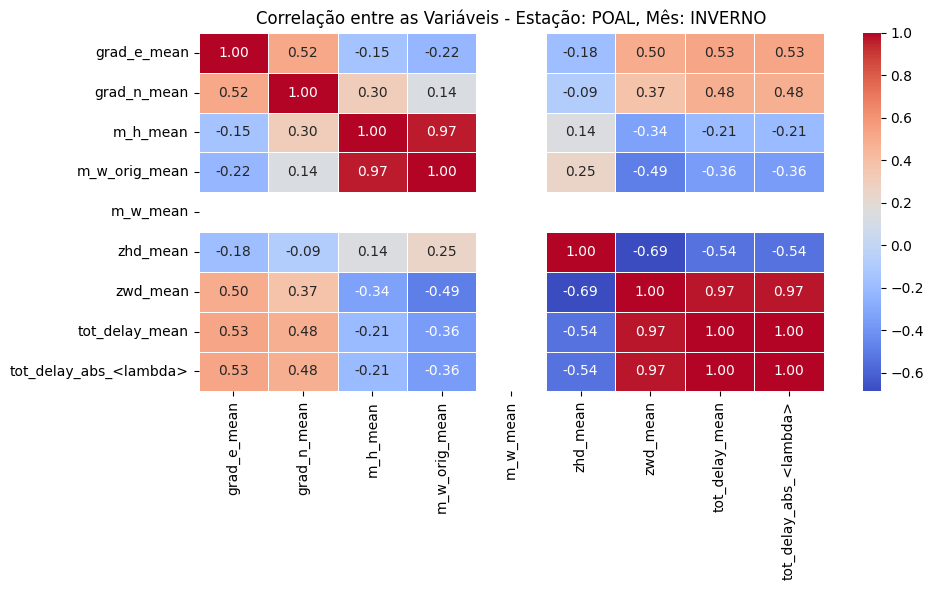

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_POAL_INVERNO.png
Correlação para a Estação: POAL, Mês: VERAO


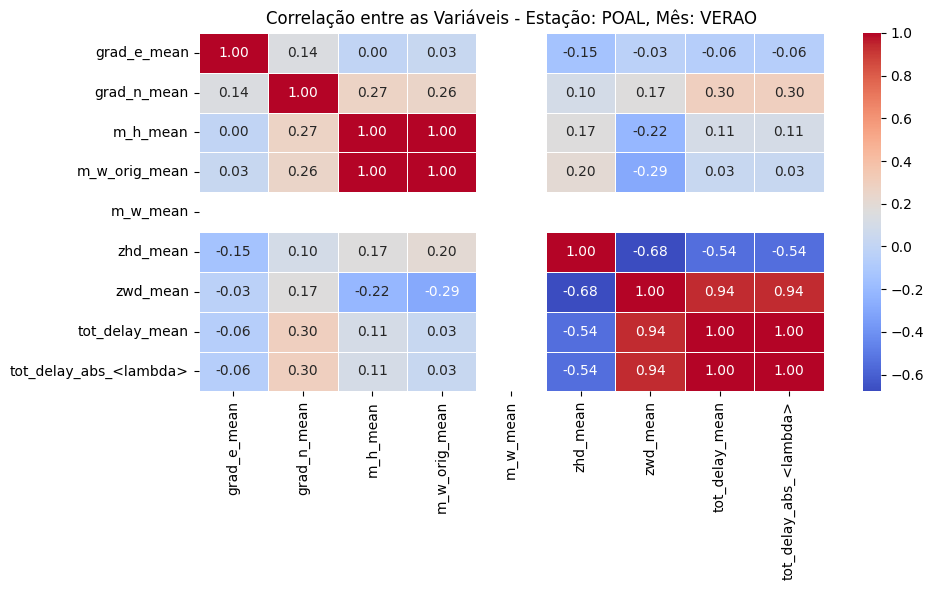

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_POAL_VERAO.png
Correlação para a Estação: POLI, Mês: INVERNO


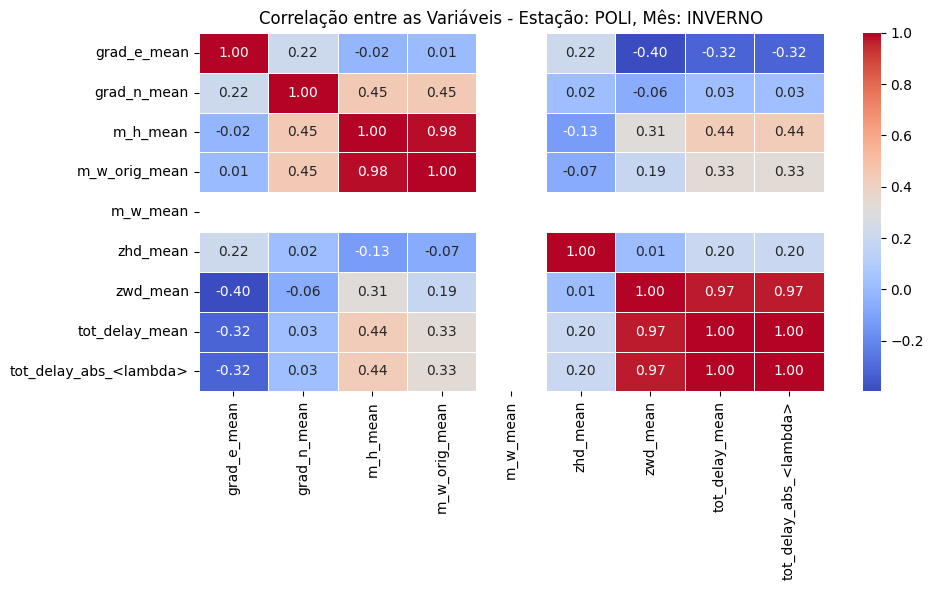

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_POLI_INVERNO.png
Correlação para a Estação: POLI, Mês: VERAO


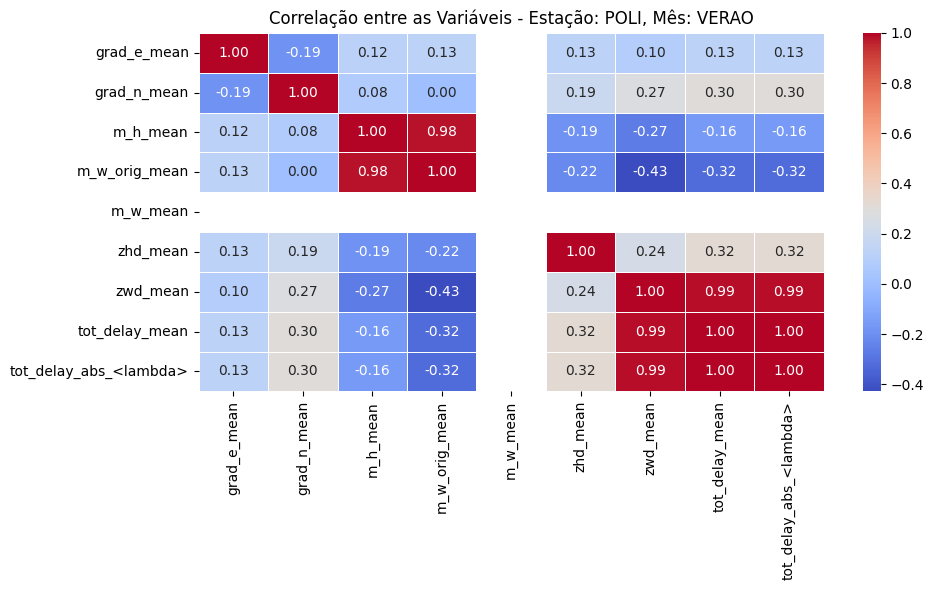

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_POLI_VERAO.png
Correlação para a Estação: SAGA, Mês: INVERNO


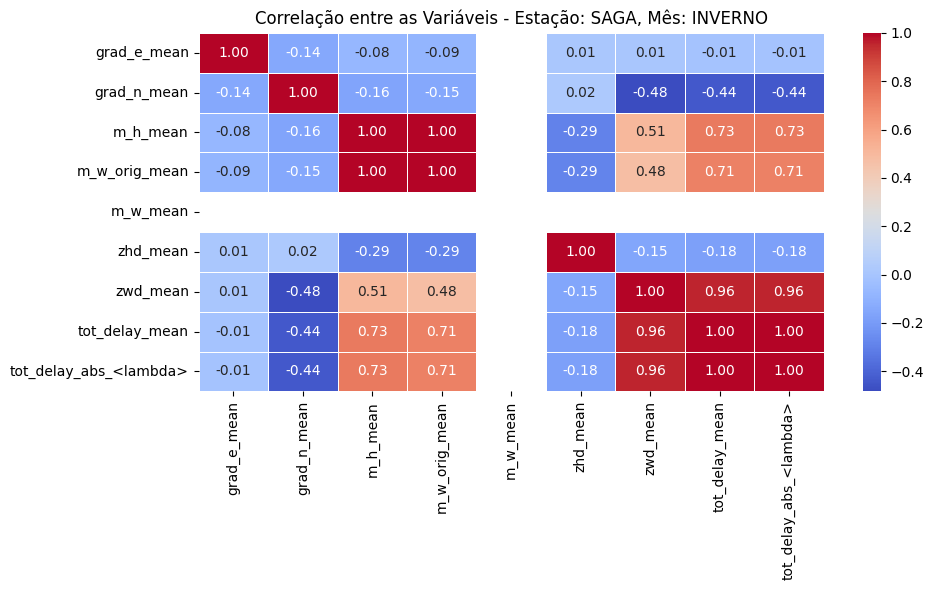

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_SAGA_INVERNO.png
Correlação para a Estação: SAGA, Mês: VERAO


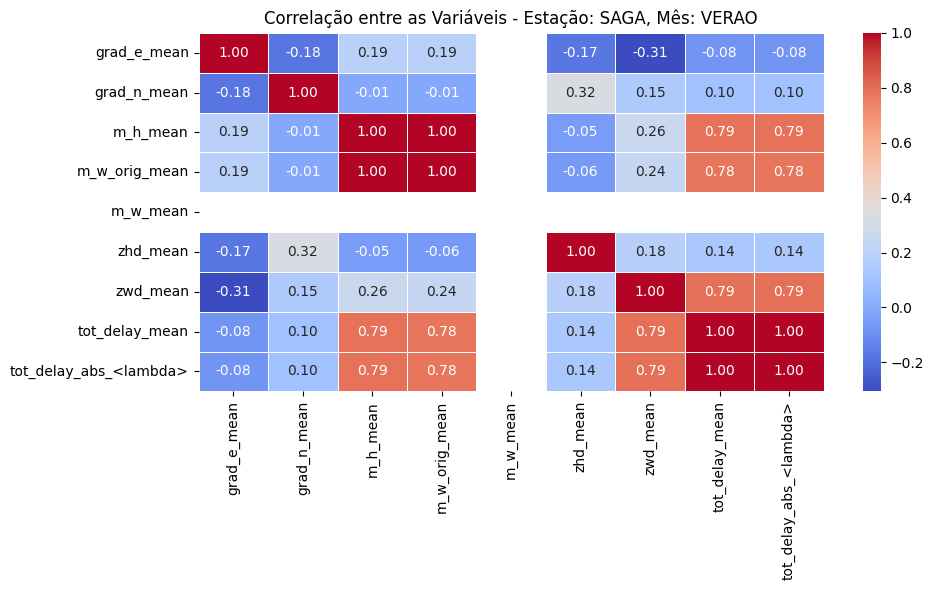

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_SAGA_VERAO.png
Correlação para a Estação: SSA1, Mês: INVERNO


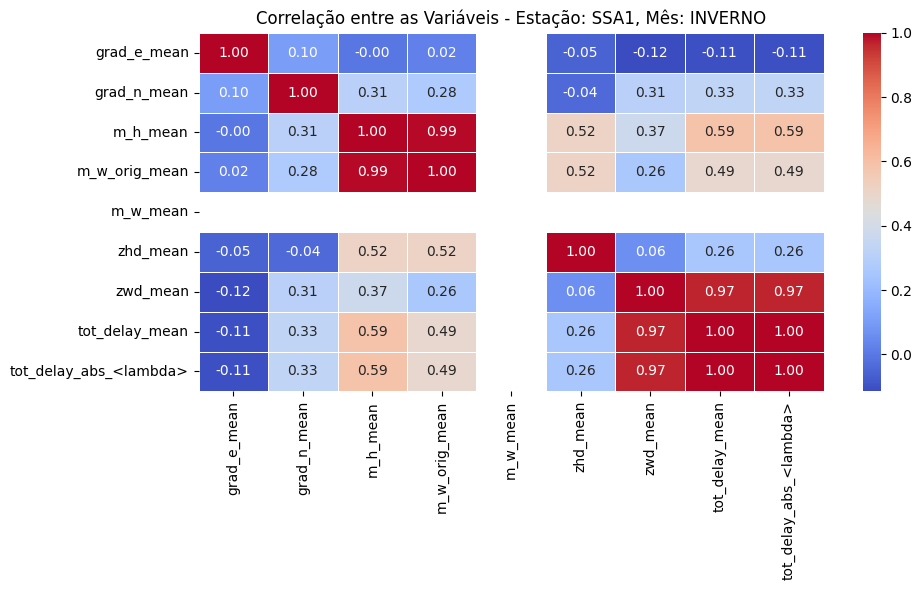

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_SSA1_INVERNO.png
Correlação para a Estação: SSA1, Mês: VERAO


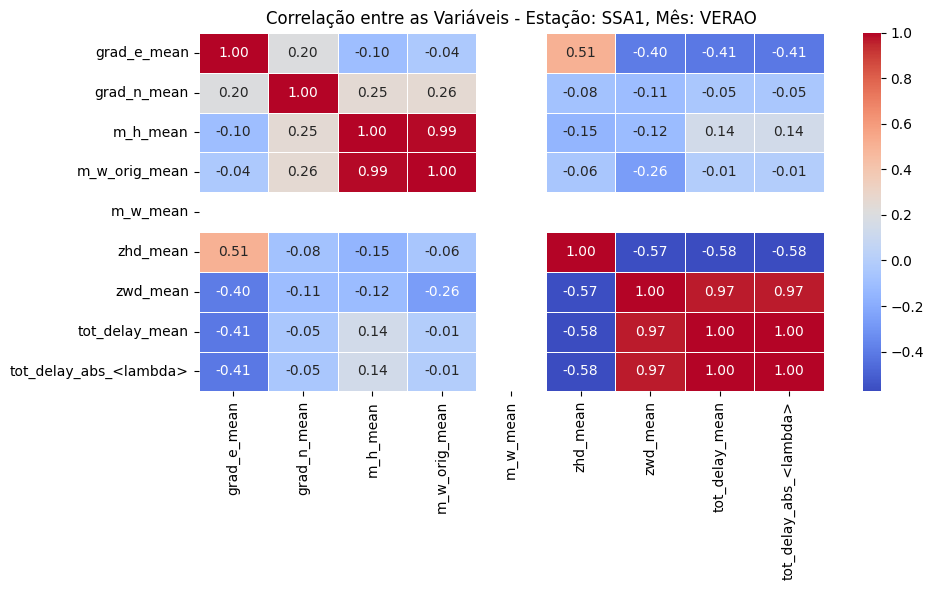

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_SSA1_VERAO.png
Correlação para a Estação: UFPR, Mês: INVERNO


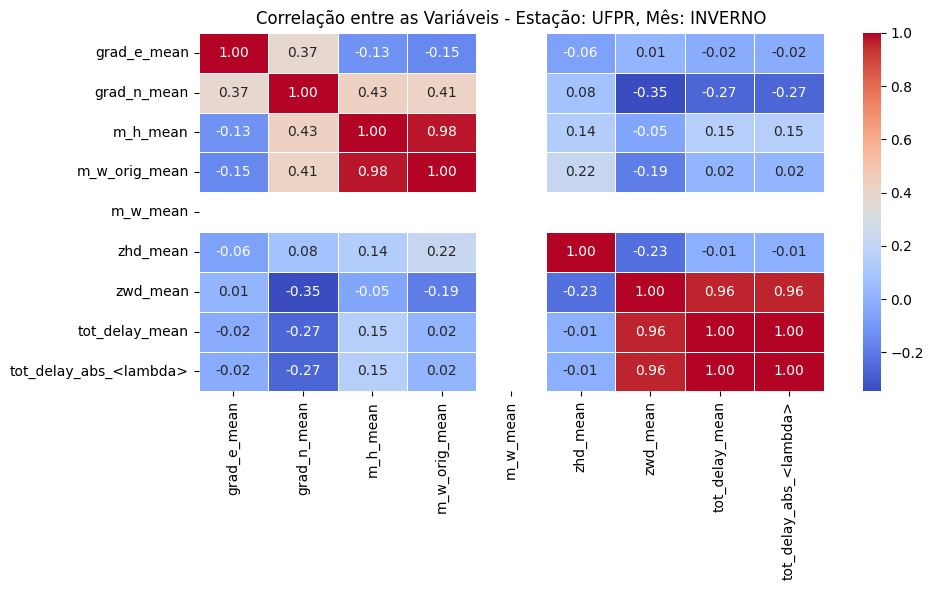

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_UFPR_INVERNO.png
Correlação para a Estação: UFPR, Mês: VERAO


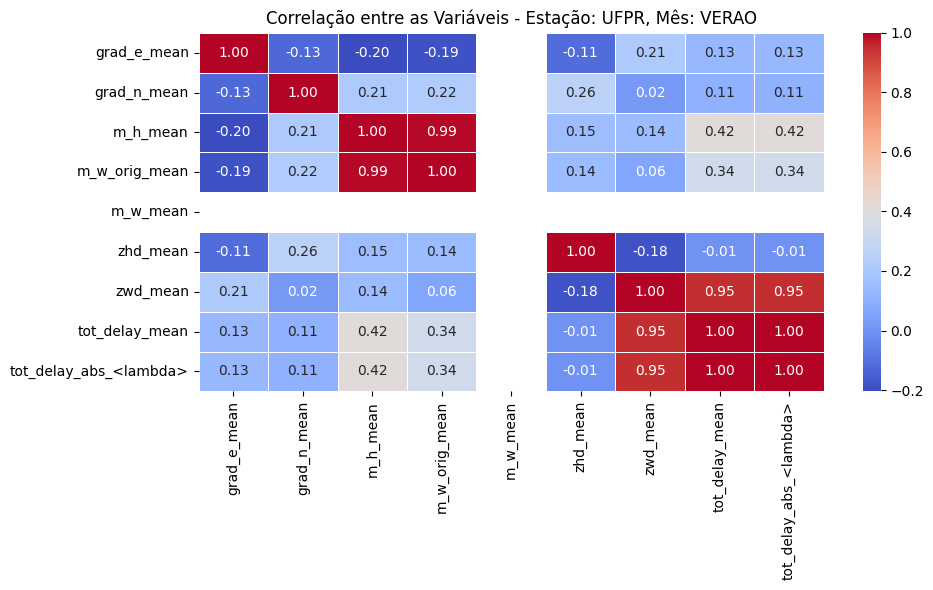

O gráfico foi salvo com sucesso em: charts\vmf3_nograd\heatmap_correlacao_UFPR_VERAO.png


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Função para calcular e plotar a correlação para cada estação e mês
def calcular_correlacao_separada(daily_stats):
    # Agrupar os dados por Estação e Mês
    for estacao, estacao_data in daily_stats.groupby('Estacao_'):
        for mes, mes_data in estacao_data.groupby('Mes_'):
            print(f'Correlação para a Estação: {estacao}, Mês: {mes}')

            # Selecionando as colunas numéricas para a correlação
            numerical_columns = ['grad_e_mean', 'grad_n_mean', 'm_h_mean', 'm_w_orig_mean', 'm_w_mean',
                                 'zhd_mean', 'zwd_mean', 'tot_delay_mean', 'tot_delay_abs_<lambda>']
            correlation_data = mes_data[numerical_columns]

            # Calculando a correlação
            correlation_matrix = correlation_data.corr()

            # Plotando o Heatmap
            plt.figure(figsize=(10, 6))
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
            plt.title(f'Correlação entre as Variáveis - Estação: {estacao}, Mês: {mes}')
            plt.tight_layout()

            # Caminho para salvar a imagem com base na Estação e Mês
            # output_path = f'/content/drive/My Drive/VMF3/dados/orig/heatmap_correlacao_{estacao}_{mes}.png'
            output_path = os.path.join(sc_charts_path,f'heatmap_correlacao_{estacao}_{mes}.png')
            

            # Salvando a imagem
            plt.savefig(output_path)

            # Exibindo o gráfico
            plt.show()

            print(f'O gráfico foi salvo com sucesso em: {output_path}')

# Chama a função para calcular a correlação
calcular_correlacao_separada(daily_stats)


Valores únicos na coluna 'Mes_': ['VERAO' 'INVERNO']
Dados para verão: 310 linhas
Dados para inverno: 310 linhas


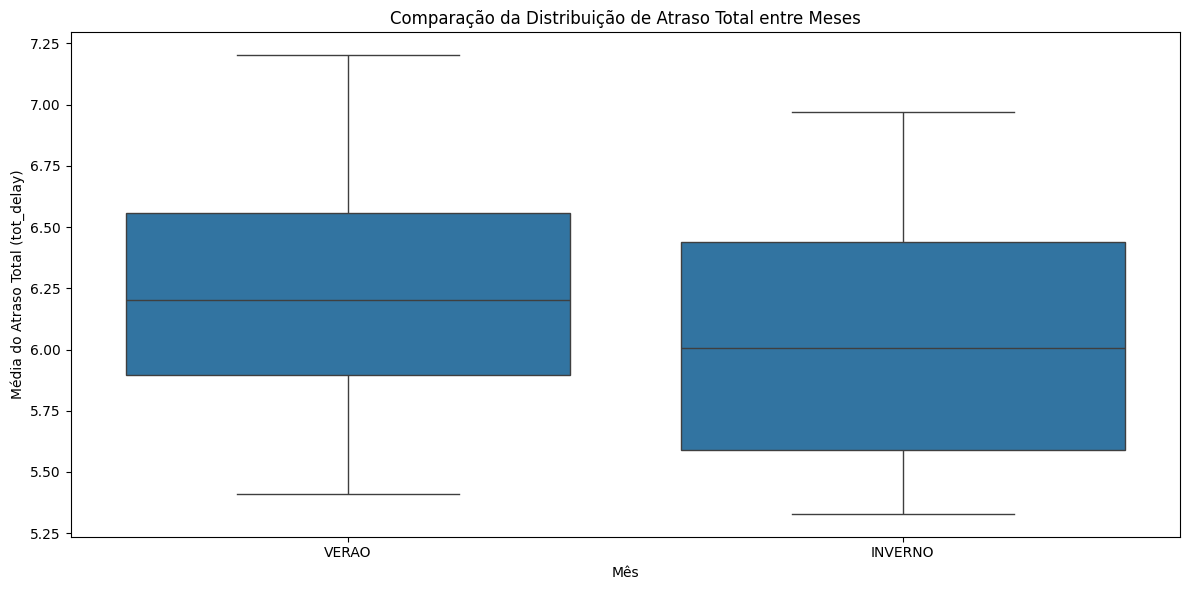

O gráfico dos meses foi salvo com sucesso em: charts\vmf3_nograd\boxplot_tot_delay_meses.png


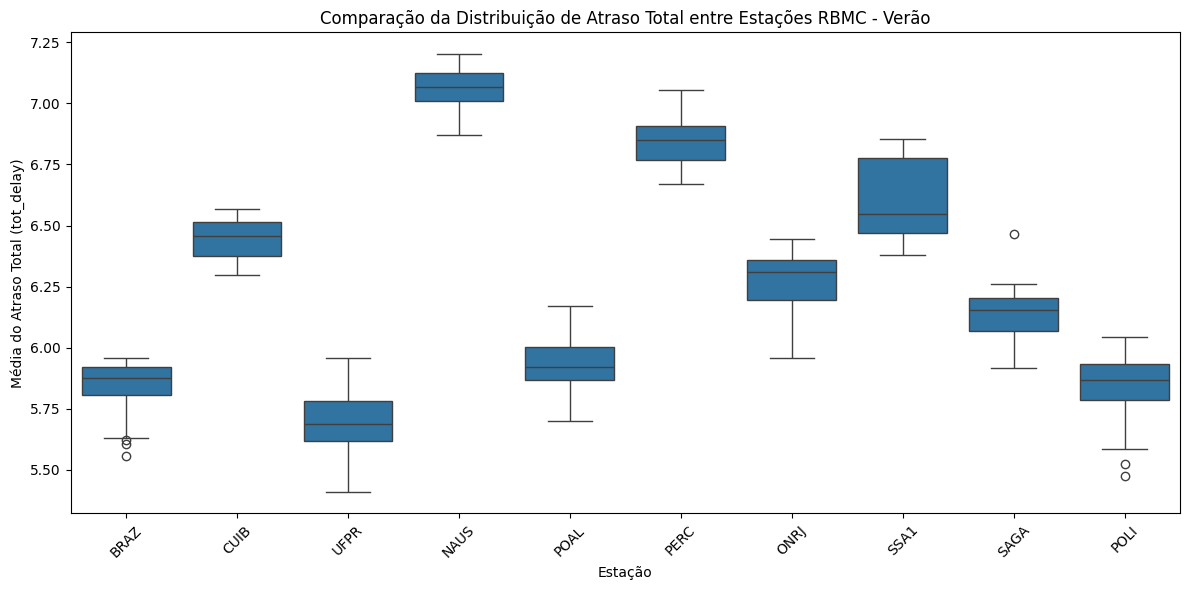

O gráfico de verão foi salvo com sucesso em: charts\vmf3_nograd\boxplot_tot_delay_estacoes_verao.png


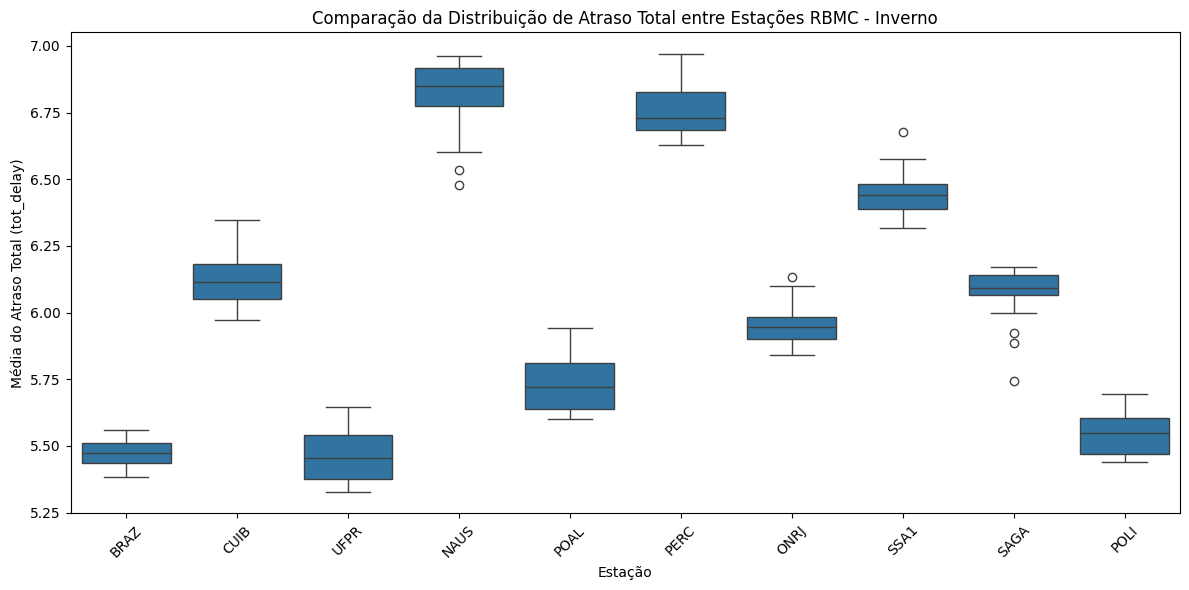

O gráfico de inverno foi salvo com sucesso em: charts\vmf3_nograd\boxplot_tot_delay_estacoes_inverno.png


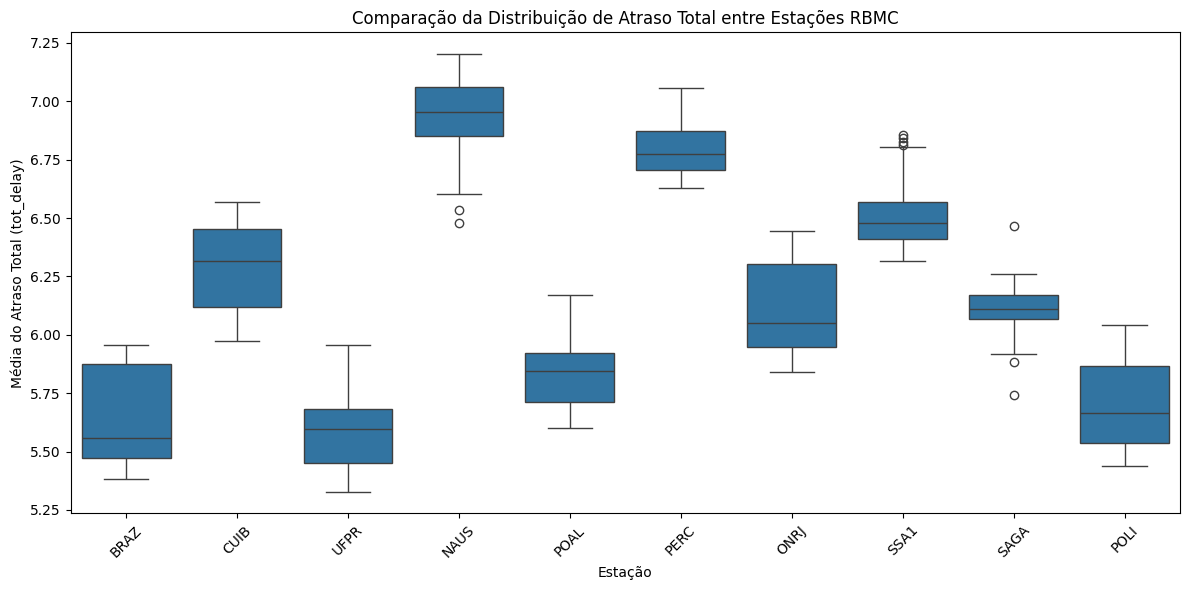

O gráfico geral das estações foi salvo com sucesso em: charts\vmf3_nograd\boxplot_tot_delay_estacoes_geral.png


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar os dados do arquivo CSV gerado anteriormente
# daily_stats = pd.read_csv('/content/drive/My Drive/VMF3/dados/orig/daily_stats.csv')
daily_stats = pd.read_csv(daily_stats_path)

# Verificar valores únicos na coluna 'Mes_'
print("Valores únicos na coluna 'Mes_':", daily_stats['Mes_'].unique())

# Filtrar dados para verão (VERAO) e inverno (INVERNO)
verao_data = daily_stats[daily_stats['Mes_'].str.strip().str.upper() == 'VERAO']
inverno_data = daily_stats[daily_stats['Mes_'].str.strip().str.upper() == 'INVERNO']

# Verificar se há dados após a filtragem
print(f"Dados para verão: {verao_data.shape[0]} linhas")
print(f"Dados para inverno: {inverno_data.shape[0]} linhas")

# Gráfico de comparação da distribuição de atraso total entre meses
plt.figure(figsize=(12, 6))
sns.boxplot(x='Mes_', y='tot_delay_mean', data=daily_stats)
plt.xlabel('Mês')
plt.ylabel('Média do Atraso Total (tot_delay)')
plt.title('Comparação da Distribuição de Atraso Total entre Meses')
plt.tight_layout()

# Caminho para salvar o gráfico de meses
# output_path_meses = '/content/drive/My Drive/VMF3/dados/orig/boxplot_tot_delay_meses.png'
output_path_meses = os.path.join(sc_charts_path,'boxplot_tot_delay_meses.png')

# Salvando o gráfico de meses
plt.savefig(output_path_meses)
plt.show()

print(f'O gráfico dos meses foi salvo com sucesso em: {output_path_meses}')

if not verao_data.empty:
    # Gráfico de boxplot para verão (VERAO)
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Estacao_', y='tot_delay_mean', data=verao_data)
    plt.xlabel('Estação')
    plt.ylabel('Média do Atraso Total (tot_delay)')
    plt.title('Comparação da Distribuição de Atraso Total entre Estações RBMC - Verão')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Caminho para salvar a imagem de verão
    # output_path_verao = '/content/drive/My Drive/VMF3/dados/orig/boxplot_tot_delay_estacoes_verao.png'
    output_path_verao = os.path.join(sc_charts_path,'boxplot_tot_delay_estacoes_verao.png')

    # Salvando a imagem de verão
    plt.savefig(output_path_verao)
    plt.show()

    print(f'O gráfico de verão foi salvo com sucesso em: {output_path_verao}')
else:
    print("Nenhum dado disponível para verão.")

if not inverno_data.empty:
    # Gráfico de boxplot para inverno (INVERNO)
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Estacao_', y='tot_delay_mean', data=inverno_data)
    plt.xlabel('Estação')
    plt.ylabel('Média do Atraso Total (tot_delay)')
    plt.title('Comparação da Distribuição de Atraso Total entre Estações RBMC - Inverno')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Caminho para salvar a imagem de inverno
    # output_path_inverno = '/content/drive/My Drive/VMF3/dados/orig/boxplot_tot_delay_estacoes_inverno.png'
    output_path_inverno = os.path.join(sc_charts_path,'boxplot_tot_delay_estacoes_inverno.png')

    # Salvando a imagem de inverno
    plt.savefig(output_path_inverno)
    plt.show()

    print(f'O gráfico de inverno foi salvo com sucesso em: {output_path_inverno}')
else:
    print("Nenhum dado disponível para inverno.")

# Gráfico de comparação da distribuição de atraso total entre estações (geral)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Estacao_', y='tot_delay_mean', data=daily_stats)
plt.xlabel('Estação')
plt.ylabel('Média do Atraso Total (tot_delay)')
plt.title('Comparação da Distribuição de Atraso Total entre Estações RBMC')
plt.xticks(rotation=45)
plt.tight_layout()

# Caminho para salvar o gráfico geral de estações
# output_path_estacoes_geral = '/content/drive/My Drive/VMF3/dados/orig/boxplot_tot_delay_estacoes_geral.png'
output_path_estacoes_geral = os.path.join(sc_charts_path,'boxplot_tot_delay_estacoes_geral.png')

# Salvando o gráfico geral de estações
plt.savefig(output_path_estacoes_geral)
plt.show()

print(f'O gráfico geral das estações foi salvo com sucesso em: {output_path_estacoes_geral}')


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Carregar os dados do arquivo CSV
# daily_stats = pd.read_csv("seu_arquivo.csv")

# Exemplo de como seus dados podem ser estruturados:
# daily_stats = pd.DataFrame({
#     'Estacao_': ['BRAZ', 'BRAZ', 'BRAZ', 'CUIB', 'CUIB'],
#     'Mes_': ['VERAO', 'VERAO', 'VERAO', 'VERAO', 'VERAO'],
#     'Tempo_': ['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-01', '2020-01-02'],
#     'grad_e_mean': [0.5, 0.6, 0.7, 0.8, 0.9],
#     'grad_n_mean': [1.5, 1.6, 1.7, 1.8, 1.9]
# })

# Converte a coluna 'Tempo_' para o tipo datetime
daily_stats['Tempo_'] = pd.to_datetime(daily_stats['Tempo_'])

# Filtra os dados para o ano de 2020 e os meses de janeiro e julho
dados_filtrados = daily_stats[(daily_stats['Tempo_'].dt.year == 2020) &
                               (daily_stats['Tempo_'].dt.month.isin([1, 7]))]

# Lista de estações RBMC
estacoes_rbmc = daily_stats['Estacao_'].unique()

# Caminho da pasta onde as imagens serão salvas
# output_dir = '/content/drive/My Drive/VMF3/dados/orig/'
output_dir = sc_charts_path

# Cria a pasta caso ela não exista
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Função para plotar os gráficos
def plot_timeseries(df, estacao, y_limits):
    # Filtra os dados da estação
    station_data = df[df['Estacao_'] == estacao]

    # Verifica se há dados para a estação e os meses de janeiro e julho
    if station_data.empty:
        print(f"Sem dados para janeiro e/ou julho na estação {estacao}.")
        return

    # Cria o gráfico para os gradientes troposféricos (grad_e e grad_n)
    plt.figure(figsize=(10, 6))

    # Plota o gradiente em 'E' (grad_e)
    plt.scatter(station_data['Tempo_'], station_data['grad_e_mean'], label='Gradiente Leste (grad_e)', color='blue', marker='o', s=50)

    # Plota o gradiente em 'N' (grad_n)
    plt.scatter(station_data['Tempo_'], station_data['grad_n_mean'], label='Gradiente Norte (grad_n)', color='red', marker='x', s=50)

    # Adiciona título e labels aos eixos
    plt.title(f"Séries Temporais dos Gradientes Troposféricos | Estação {estacao}", fontsize=14)
    plt.xlabel('Tempo', fontsize=12)
    plt.ylabel('Gradiente Troposférico (m/s)', fontsize=12)

    # Exibe a legenda
    plt.legend()

    # Formatação para exibir as datas corretamente
    plt.xticks(rotation=45)
    plt.grid(True)

    # Ajusta os limites do eixo Y conforme os valores globalmente calculados
    plt.ylim(y_limits)

    # Exibe o gráfico
    # plt.show()

    # Salva o gráfico na pasta especificada
    file_path = os.path.join(output_dir, f"grafico_{estacao}.png")
    # plt.tight_layout()
    plt.savefig(file_path)
    plt.close()
    print(f"Gráfico salvo em {file_path}")

# Calcular os limites de Y (mínimo e máximo) com base nos dados globais
y_min = min(dados_filtrados['grad_e_mean'].min(), dados_filtrados['grad_n_mean'].min())
y_max = max(dados_filtrados['grad_e_mean'].max(), dados_filtrados['grad_n_mean'].max())

# Define a margem para os limites
margin = 0.1  # 10% de margem
y_limits = (y_min - margin * abs(y_min), y_max + margin * abs(y_max))

# Itera sobre todas as estações e gera o gráfico para cada uma, usando os mesmos limites de Y
for estacao in estacoes_rbmc:
    plot_timeseries(dados_filtrados, estacao, y_limits)


Gráfico salvo em charts\vmf3_nograd\grafico_BRAZ.png
Gráfico salvo em charts\vmf3_nograd\grafico_CUIB.png
Gráfico salvo em charts\vmf3_nograd\grafico_UFPR.png
Gráfico salvo em charts\vmf3_nograd\grafico_NAUS.png
Gráfico salvo em charts\vmf3_nograd\grafico_POAL.png
Gráfico salvo em charts\vmf3_nograd\grafico_PERC.png
Gráfico salvo em charts\vmf3_nograd\grafico_ONRJ.png
Gráfico salvo em charts\vmf3_nograd\grafico_SSA1.png
Gráfico salvo em charts\vmf3_nograd\grafico_SAGA.png
Gráfico salvo em charts\vmf3_nograd\grafico_POLI.png
